# Assignment 3
## Image Gradients

在这节任务中，我们会引入 TinyImageNet数据集以及一个在该数据集上预训练好的深度 CNN 模型。我们使用预训练好的模型计算图片的梯度，然后用这些得到的图片梯度生成显著图和 fooling images

In [1]:
import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Introducing TinyImageNet

TinyImageNet 数据集是 ILSVRC-2012 数据集的一部分，它包含 200 个类，对于每一个类有 500 张训练图片和 50 张验证图片以及 50 张测试图片。所有图片的大小都是 64 x 64，所有训练集和验证集的标签都已经给出，但是验证集的标签是保留的

我们进一步将整个 TinyImageNet 数据集分为大小相同的两部分，每个部分包含 100 个类。我们将这两部分取名为 TinyImageNet-100-A 和 TinyImageNet-100-B，在这节的任务中我们用到 TinyImageNet-100-A

完整的 TinyImageNet-100-A 数据集占用约 250 MB 的磁盘空间，将完整的 TinyImageNet-100-A 加载到内存则需要大约 2.8 GB

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean = True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


## TinyImageNet-100-A classes

因为 ImageNet 是基于 WordNet 文本体，所以 ImageNet (或 TinyImageNet) 中的每个类实际上都有几个不同的名称，例如，pop bottle 和 soda bottle 都是同一类别的有效名称。可以运行下面单元查看一下 TinyImageNet-100-A 所有类的有效名称

In [3]:
for i, names in enumerate(data['class_names']):
    print(i, ' '.join('"%s"' % name for name in names))

0 "Egyptian cat"
1 "reel"
2 "volleyball"
3 "rocking chair" "rocker"
4 "lemon"
5 "bullfrog" "Rana catesbeiana"
6 "basketball"
7 "cliff" "drop" "drop-off"
8 "espresso"
9 "plunger" "plumber's helper"
10 "parking meter"
11 "German shepherd" "German shepherd dog" "German police dog" "alsatian"
12 "dining table" "board"
13 "monarch" "monarch butterfly" "milkweed butterfly" "Danaus plexippus"
14 "brown bear" "bruin" "Ursus arctos"
15 "school bus"
16 "pizza" "pizza pie"
17 "guinea pig" "Cavia cobaya"
18 "umbrella"
19 "organ" "pipe organ"
20 "oboe" "hautboy" "hautbois"
21 "maypole"
22 "goldfish" "Carassius auratus"
23 "potpie"
24 "hourglass"
25 "seashore" "coast" "seacoast" "sea-coast"
26 "computer keyboard" "keypad"
27 "Arabian camel" "dromedary" "Camelus dromedarius"
28 "ice cream" "icecream"
29 "nail"
30 "space heater"
31 "cardigan"
32 "baboon"
33 "snail"
34 "coral reef"
35 "albatross" "mollymawk"
36 "spider web" "spider's web"
37 "sea cucumber" "holothurian"
38 "backpack" "back pack" "knaps

## Visual Examples

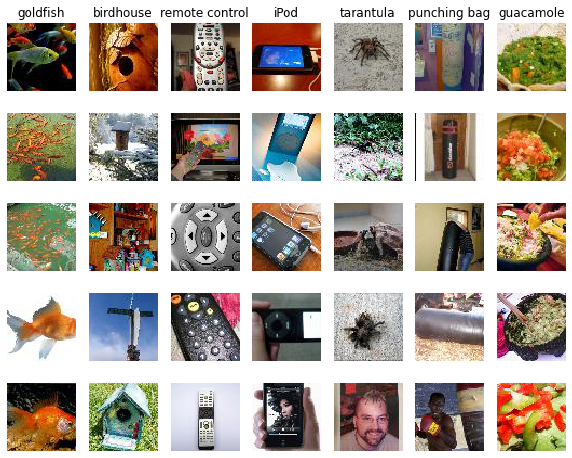

In [4]:
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(data['y_train'] == class_idx)
    train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(data['class_names'][class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.show()

## Pretrained model

我们已经预训练好了一个深度 CNN 模型，它有 9 层卷积层（带 spatial batch norm）和一层全连接层（带 batch norm）

In [5]:
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

## Pretained model perforamnce

运行下面的单元测试一下预训练模型在随机选取的训练集和验证集上的表现。训练准确率应该在 90% 左右，而验证准确率在 60% 左右。显然，这出现了过拟合，但它还是适用于我们的可视化实验

In [6]:
batch_size = 100

# Test the model on training data
mask = np.random.randint(data['X_train'].shape[0], size=batch_size)
X, y = data['X_train'][mask], data['y_train'][mask]
y_pred = model.loss(X).argmax(axis=1)
print('Training accuracy: ', (y_pred == y).mean())

# Test the model on validation data
mask = np.random.randint(data['X_val'].shape[0], size=batch_size)
X, y = data['X_val'][mask], data['y_val'][mask]
y_pred = model.loss(X).argmax(axis=1)
print('Validation accuracy: ', (y_pred == y).mean())

Training accuracy:  0.9
Validation accuracy:  0.61


## 显著图

使用预训练好的模型可以计算每个类的显著图。如论文 (Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps) 中的描述，我们应该计算图像相对于非标准化分类得分的梯度，而不是相对于标准化分类概率的梯度

在计算显著图时，确保在 'test' 模式下计算模型



In [7]:
def compute_saliency_maps(X, y, model):
    """
    计算每个类的显著图

    输入：
    - X：输入图片，大小为 (N, 3, H, W)
    - y：X 的标签，大小为 (N,)
    - model：PretrainedCNN 用来计算显著图

    返回：
    - saliency：大小为 (N, H, W) 的数组给出输入图片的显著图
    """
    saliency = None
    # 使用 PretraineddCNN 中的 forward 函数和
    # backward 函数计算 ground-truth class y 的非标准化分类得分的梯度
    N = X.shape[0]
    scores, cache = model.forward(X, mode = 'test')
    dscores = np.zeros_like(scores)
    dscores[range(N), y] = 1
    dX, _ = model.backward(dscores, cache)
    saliency = np.max(np.abs(dX), axis = 1)
    return saliency

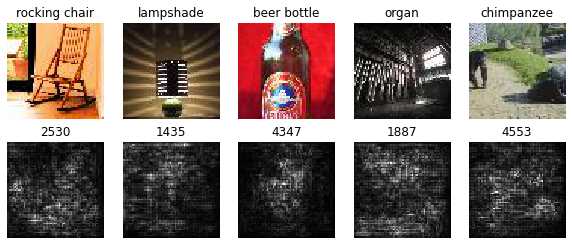

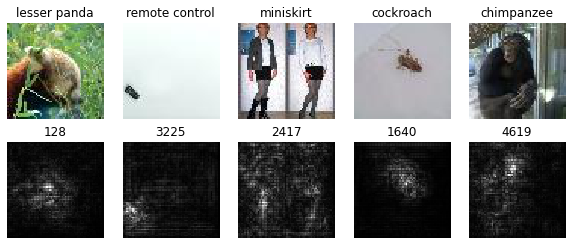

In [8]:
def show_saliency_maps(mask):
    mask = np.asarray(mask)
    X = data['X_val'][mask]
    y = data['y_val'][mask]

    saliency = compute_saliency_maps(X, y, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(X[i], data['mean_image']))
        plt.axis('off')
        plt.title(data['class_names'][y[i]][0])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i])
        plt.axis('off')
    plt.gcf().set_size_inches(10, 4)
    plt.show()

# Show some random images
mask = np.random.randint(data['X_val'].shape[0], size=5)
show_saliency_maps(mask)
  
# These are some cherry-picked images that should give good results
show_saliency_maps([128, 3225, 2417, 1640, 4619])

## Fooling Images

我们还可以使用图片的梯度生成 fooling images (添加特定噪声到原始图像,使神经网络误识别)

输入一张图片和目标类，我们可以在图像上沿着梯度上升的方向以最大化目标类，当网络将图像分类为目标类时停止。下面是生成 fooling images 的实现

In [10]:
def make_fooling_image(X, target_y, model):
    """
    产生一个接近于 X 的 fooling image，但模型将其分类为 target_y

    输入：
    - X：输入图像，大小为 (1, 3,, 64, 64)
    - target_y：整数值，在 [0, 100)
    - model：PretrainedCNN

    返回：
    - X_fooling：和 X 接近的一张图片，模型分类为 target_y
    """
    X_fooling = X.copy()
    # 在目标分类得分上沿着梯度上升的方向通过 model.forward 方法计算得分
    # 通过 model.backward 方法计算梯度
    # 对于大多数的图片来说，在 100 个迭代内就可以生成 fooling image
    N = X.shape[0]
    reg = 5e-5
    from cs231n.layers import softmax_loss
    for i in range(100):
        R = X_fooling - X
        scores, cache = model.forward(X_fooling, mode = 'test')
        loss, dscores = softmax_loss(scores, target_y)
        loss += 0.5 * reg * np.sum(R * R)
        print('softmax loss: ', loss)
        y_pred = np.argmax(scores)
        print('target class index ', target_y, ' current class index: ', y_pred)
        if target_y == y_pred:
            print('iter num: ', i)
            break
        else:
            df, _ = model.backward(dscores, cache)
            dX = reg * R + df
            X_fooling -= 6000 * dX
    return X_fooling

def make_fooling_image_naive(X, target_y, model):
    X_fooling = X.copy()
    iter = 0
    current_predict = -1
    labels = [target_y]
    while iter < 100 and current_predict != target_y:
        scores, cache = model.forward(X_fooling, mode = 'test')
        current_predict = scores[0].argmax()
        if current_predict != target_y:
            if iter != 0:
                print(np.argmax(scores_old - scores))
                labels.append(np.argmax(scores_old - scores).item())
            dscores = np.zeros(scores.shape)
            dscores[:,target_y] = 1000
            dscores[:,current_predict] = min(-scores[:,current_predict] + scores[:,target_y],-100)  
            w, _ = model.backward(dscores, cache)
            X_fooling +=w

            iter+=1
            scores_old = scores
            print("iteration: ", iter, "  predict: ", current_predict)
    return X_fooling, labels

softmax loss:  6.912956714630127
target class index  67  current class index:  21
softmax loss:  10.887339916992188
target class index  67  current class index:  5
softmax loss:  16.062559645843507
target class index  67  current class index:  93
softmax loss:  10.45850079574585
target class index  67  current class index:  73
softmax loss:  6.793751758766175
target class index  67  current class index:  56
softmax loss:  4.271714349202812
target class index  67  current class index:  67
iter num:  5


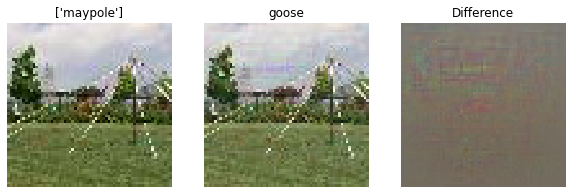

In [23]:
# 随机选取一些验证集上正确分给的图片产生 fooling image
while True:
    i = np.random.randint(data['X_val'].shape[0])
    X = data['X_val'][i:i+1]
    y = data['y_val'][i:i+1]
    y_pred = model.loss(X)[0].argmax()
    if y_pred == y: break

target_y = 67
#X_fooling, labels = make_fooling_image_navie(X, target_y, model)
X_fooling = make_fooling_image(X, target_y, model)
# Make sure that X_fooling is classified as y_target
scores = model.loss(X_fooling)
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
plt.subplot(1, 3, 1)
plt.imshow(deprocess_image(X, data['mean_image']))
plt.axis('off')
plt.title(np.array(data['class_names'])[y][0])
plt.subplot(1, 3, 2)
plt.imshow(deprocess_image(X_fooling, data['mean_image'], renorm=True))
plt.title(data['class_names'][target_y][0])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(deprocess_image(X - X_fooling, data['mean_image']))
plt.axis('off')
plt.show()